In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.engine0d as ue0d
import utils.visualizer as uv

In [2]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2

In [3]:
plt.rcParams["animation.html"] = "jshtml"

In [4]:
def make_linear_profile_ice(h_ice, T_ib, T_is, N_cells):
    dz_cells = np.ones(N_cells)*(h_ice/N_cells)
    T_cells = T_ib + np.arange(0.5, N_cells)/N_cells * (T_is - T_ib)
    return dz_cells, T_ib, T_cells, T_is

In [5]:
make_linear_profile_ice(2.0, 0.0, -10.0, 10)

(array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]),
 0.0,
 array([-0.5, -1.5, -2.5, -3.5, -4.5, -5.5, -6.5, -7.5, -8.5, -9.5]),
 -10.0)

# 1.Тестирование функции ice_freezing_0d (и сравнение с ice_freezing)

In [ ]:
def test_ice_freezing_0d(N, # количество ячеек в сетке вывода
                         N_time_steps,
                         N_pseudoiter,
                         time_step,
                         thickness_init,
                         T_a,
                         T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_prev, thickness_prev = 0.0, 0.0
    T_ia_new, thickness_new = T_a(0.0)/2.0 , thickness_init
    
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
   
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, thickness_prev = T_ia_new, thickness_new 
        
        T_ia_new, thickness_new = \
        ue0d.ice_freezing_0d(Toi=T_ib_init,
                             Tia_init=T_ia_prev,
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             thickness_i_init=thickness_prev,
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step)
        
        # вывод
        dz_cells_ice, T_ib, T_cells, T_is = make_linear_profile_ice(h_ice=thickness_new,
                                                                    T_ib=T_o(time),
                                                                    T_is=T_ia_new,
                                                                    N_cells=N)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_ice_freezing_1d(N,
                         N_time_steps,
                         N_pseudoiter,
                         time_step,
                         thickness_init,
                         T_a,
                         T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_new = T_a(0.0)/2.0
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    T_ia_prev, dz_cells_ice_prev =  T_is_init, dz_cells_ice_init
    dz_cells_ice_new = dz_cells_ice_init
    T_cells_prev , T_cells_new = T_cells_init, T_cells_init
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, dz_cells_ice_prev, T_cells_prev = T_ia_new, dz_cells_ice_new, T_cells_new 
        
        T_cells_new, T_ia_new, dz_cells_ice_new = \
        ue.ice_freezing(Toi=T_ib_init,
                        Ti=T_cells_prev,
                        Tia=T_ia_prev,
                        F_atm=F_atm,
                        F_ocn=F_ocn,
                        F_sw=0.0,
                        dzi=dz_cells_ice_prev,
                        salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                        N_pseudoiter=N_pseudoiter,
                        time_step=time_step,
                        tol=1e-12)
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_ia_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
# расчет тестов
test_ice_freezing_process_0d = test_ice_freezing_0d(N=10,
                                                    N_time_steps=500,
                                                    N_pseudoiter=50,
                                                    time_step=3600.0,
                                                    thickness_init=1.0,
                                                    T_a=lambda time: -20.0,
                                                    T_o=lambda time: ue.Tf_i(30.0))

test_ice_freezing_process_1d = test_ice_freezing_1d(N=10,
                                                    N_time_steps=500,
                                                    N_pseudoiter=50,
                                                    time_step=3600.0,
                                                    thickness_init=1.0,
                                                    T_a=lambda time: -20.0,
                                                    T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
# анимация
uv.animate([test_ice_freezing_process_0d, test_ice_freezing_process_1d], names=['0D', '1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_ice_freezing_process_1d,
                  process_data=test_ice_freezing_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 2.Тестирование функции ice_melting_0d (и сравнение с ice_melting)

In [ ]:
def test_ice_melting_0d(N,
                        N_time_steps,
                        N_pseudoiter,
                        time_step,
                        thickness_init,
                        T_a,
                        T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_prev, thickness_prev = 0.0, 0.0
    T_ia_new, thickness_new = T_a(0.0)/2.0 , thickness_init
    
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, thickness_prev = T_ia_new, thickness_new
        
        T_ia_new, thickness_new = \
        ue0d.ice_freezing_0d(Toi=T_ib_init,
                             Tia_init=T_ia_prev,
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             thickness_i_init=thickness_prev,
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step)
        
        if (T_ia_new >= ue.Tf_i(1.0)):
            
            T_ia_new = ue.Tf_i(1.0)
            
            thickness_new = \
            ue0d.ice_melting_0d(Toi=T_ib_init,
                                F_atm=F_atm,
                                F_ocn=F_ocn,
                                thickness_i_init=thickness_prev,
                                N_pseudoiter=N_pseudoiter,
                                time_step=time_step)
            
            print('ice melting')
            
        else:
            print('ice freezing')
        
        # вывод
        
        dz_cells_ice, T_ib, T_cells, T_is = make_linear_profile_ice(h_ice=thickness_new,
                                                                    T_ib=T_o(time),
                                                                    T_is=T_ia_new,
                                                                    N_cells=N)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_ice_melting_1d(N,
                        N_time_steps,
                        N_pseudoiter,
                        time_step,
                        thickness_init,
                        T_a,
                        T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_ia_new = T_a(0.0)/2.0
    dz_cells_ice_init, T_ib_init, T_cells_init, T_is_init = make_linear_profile_ice(h_ice=thickness_init,
                                                                                    T_ib=T_o(0.0),
                                                                                    T_is=T_ia_new,
                                                                                    N_cells=N)
    
    T_ia_prev, dz_cells_ice_prev =  T_is_init, dz_cells_ice_init
    dz_cells_ice_new = dz_cells_ice_init
    T_cells_prev , T_cells_new = T_cells_init, T_cells_init
    
    process = ue.Process([dz_cells_ice_init], [np.zeros(10)],
                         [0.0],
                         [T_ib_init], [T_cells_init], [T_is_init], [np.zeros(10)*np.nan], [np.nan],
                         [[ue.rho_i]*N],
                         [False])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_ia_prev, dz_cells_ice_prev, T_cells_prev = T_ia_new, dz_cells_ice_new, T_cells_new 
        
        T_cells_new, T_ia_new, dz_cells_ice_new = \
        ue.ice_freezing(Toi=T_ib_init,
                        Ti=T_cells_prev,
                        Tia=T_ia_prev,
                        F_atm=F_atm,
                        F_ocn=F_ocn,
                        F_sw=0.0,
                        dzi=dz_cells_ice_prev,
                        salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                        N_pseudoiter=N_pseudoiter,
                        time_step=time_step,
                        tol=1e-12)
        
        if (T_ia_new >= ue.Tf_i(1.0)):
            
            T_ia_new = ue.Tf_i(1.0)
            
            T_cells_new, dz_cells_ice_new = \
            ue.ice_melting(Toi=T_ib_init,
                           Ti=T_cells_prev,
                           Tia_old=T_ia_prev,
                           F_atm=F_atm,
                           F_ocn=F_ocn,
                           F_sw=0.0,
                           dzi=dz_cells_ice_prev,
                           salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                           N_pseudoiter=N_pseudoiter,
                           time_step=time_step,
                           tol=1e-12)
            
            print('ice melting')
            
        else:
            print('ice freezing')
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [np.zeros(10)], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_ia_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [np.zeros(10)*np.nan], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, np.nan)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, False)
        
        print('time = ', time)
    
    return process

In [ ]:
def warming_atmosphere(time, total_time, low_temp, high_temp):
    if (time <= total_time/2.0):
        return low_temp + (high_temp - low_temp)/(0.5*total_time)*time
    return high_temp

In [ ]:
plt.figure(figsize=(20, 10))
T_interval = np.arange(500)*3600
plt.plot(T_interval, [warming_atmosphere(T, 500*3600, -20.0, 10.0) for T in T_interval])
plt.grid()
plt.show()

In [ ]:
test_ice_melting_process_0d = test_ice_melting_0d(N=10,
                                                  N_time_steps=500,
                                                  N_pseudoiter=50,
                                                  time_step=3600.0,
                                                  thickness_init=1.0,
                                                  T_a=lambda time: warming_atmosphere(time, 500*3600.0, -20.0, 5.0),
                                                  T_o=lambda time: ue.Tf_i(30.0))

test_ice_melting_process_1d = test_ice_melting_1d(N=10,
                                                  N_time_steps=500,
                                                  N_pseudoiter=50,
                                                  time_step=3600.0,
                                                  thickness_init=1.0,
                                                  T_a=lambda time: warming_atmosphere(time, 500*3600.0, -20.0, 5.0),
                                                  T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
uv.animate([test_ice_melting_process_0d, test_ice_melting_process_1d], names=['0D','1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_ice_melting_process_1d,
                  process_data=test_ice_melting_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 3.Тестирование функции snow_ice_freezing_0d (и сравнение с snow_ice_freezing)

In [ ]:
def test_snow_ice_freezing_0d(N,
                              N_time_steps,
                              N_pseudoiter,
                              time_step,
                              ice_thickness_init,
                              snow_thickness_init,
                              T_a,
                              p,
                              T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_sa_new = T_a(0.0)/2.0
    T_is_new = T_a(0.0)/5.0
    dz_cells_ice_init, T_ib_init, T_ice_cells_init, T_is_init = make_linear_profile_ice(h_ice=ice_thickness_init,
                                                                                        T_ib=T_o(0.0),
                                                                                        T_is=T_is_new,
                                                                                        N_cells=N)
    
    dz_cells_snow_init, T_is_init, T_snow_cells_init, T_sa_init = make_linear_profile_ice(h_ice=snow_thickness_init,
                                                                                          T_ib=T_is_new,
                                                                                          T_is=T_sa_new,
                                                                                          N_cells=10)
    
    T_is_prev, T_sa_prev =  T_is_new, T_sa_new
    thickness_ice_prev, thickness_snow_prev = ice_thickness_init, snow_thickness_init
    thickness_ice_new, thickness_snow_new = ice_thickness_init, snow_thickness_init
    
    process = ue.Process([dz_cells_ice_init], [dz_cells_snow_init],
                         [0.0],
                         [T_ib_init], [T_ice_cells_init], [T_is_init], [T_snow_cells_init], [T_sa_init],
                         [[ue.rho_i]*N],
                         [True])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_is_prev, T_sa_prev = T_is_new, T_sa_new
        thickness_ice_prev, thickness_snow_prev = thickness_ice_new, thickness_snow_new
        
        T_is_new, T_sa_new, thickness_ice_new, thickness_snow_new = \
        ue0d.snow_ice_freezing_0d(Toi=T_ib_init,
                                  Tis_init=T_is_prev,
                                  Tsa_init=T_sa_prev,
                                  Ta=T_a(time),
                                  F_atm=F_atm,
                                  F_ocn=F_ocn,
                                  ice_thickness_init=thickness_ice_prev,
                                  snow_thickness_init=thickness_snow_prev,
                                  N_pseudoiter=N_pseudoiter,
                                  time_step=time_step,
                                  p=p(time))
        
        # вывод
        dz_cells_ice, T_ib, T_ice_cells, T_is = make_linear_profile_ice(h_ice=thickness_ice_new,
                                                                        T_ib=T_o(0.0),
                                                                        T_is=T_is_new,
                                                                        N_cells=N)
    
        dz_cells_snow, T_is_init, T_snow_cells, T_sa = make_linear_profile_ice(h_ice=thickness_snow_new,
                                                                               T_ib=T_is_new,
                                                                               T_is=T_sa_new,
                                                                               N_cells=10)
        
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [dz_cells_snow.copy()], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_ice_cells.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is)
        process.snow_temp_history = np.append(process.snow_temp_history, [T_snow_cells.copy()], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, T_sa)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, True)
        
        print('time = ', time)
    
    return process

In [ ]:
def test_snow_ice_freezing_1d(N,
                              N_time_steps,
                              N_pseudoiter,
                              time_step,
                              ice_thickness_init,
                              snow_thickness_init,
                              T_a,
                              p,
                              T_o):
    
    # форсинг
    time = 0.0
    F_ocn = lambda T: 0.0
    F_atm = lambda T: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(T_a(time) - T)
    
    # инициализация процесса
    T_sa_new = T_a(0.0)/2.0
    T_is_new = T_a(0.0)/5.0
    dz_cells_ice_init, T_ib_init, T_ice_cells_init, T_is_init = make_linear_profile_ice(h_ice=ice_thickness_init,
                                                                                        T_ib=T_o(0.0),
                                                                                        T_is=T_is_new,
                                                                                        N_cells=N)
    
    dz_cells_snow_init, T_is_init, T_snow_cells_init, T_sa_init = make_linear_profile_ice(h_ice=snow_thickness_init,
                                                                                          T_ib=T_is_new,
                                                                                          T_is=T_sa_new,
                                                                                          N_cells=10)
    
    T_is_prev, T_sa_prev =  T_is_new, T_sa_new
    dz_cells_ice_new, dz_cells_snow_new = dz_cells_ice_init, dz_cells_snow_init
    T_ice_cells_prev, T_snow_cells_prev = T_ice_cells_init, T_snow_cells_init
    T_ice_cells_new, T_snow_cells_new = T_ice_cells_init, T_snow_cells_init
    
    process = ue.Process([dz_cells_ice_init], [dz_cells_snow_init],
                         [0.0],
                         [T_ib_init], [T_ice_cells_init], [T_is_init], [T_snow_cells_init], [T_sa_init],
                         [[ue.rho_i]*N],
                         [True])
    
    # временной цикл
    for it in range(N_time_steps):
        
        time += time_step
        
        T_is_prev, T_sa_prev = T_is_new, T_sa_new
        T_ice_cells_prev, T_snow_cells_prev = T_ice_cells_new, T_snow_cells_new
        dz_cells_ice_prev, dz_cells_snow_prev = dz_cells_ice_new, dz_cells_snow_new
        
        T_ice_cells_new, T_snow_cells_new, T_is_new, T_sa_new, dz_cells_ice_new, dz_cells_snow_new = \
        ue.snow_ice_freezing(Toi=T_ib_init,
                             Ti=T_ice_cells_prev,
                             Ts=T_snow_cells_prev,
                             Tis=T_is_prev,
                             Tsa=T_sa_prev,
                             Ta=T_a(time),
                             F_atm=F_atm,
                             F_ocn=F_ocn,
                             F_sw=0.0,
                             dzi=dz_cells_ice_prev,
                             dzs=dz_cells_snow_prev,
                             salinity=make_linear_profile_ice(1.0, 4.0, 1.0, N)[2],
                             N_pseudoiter=N_pseudoiter,
                             time_step=time_step,
                             p=p(time),
                             tol=1e-12)
        
        # вывод
        process.ice_dz_history = np.append(process.ice_dz_history, [dz_cells_ice_new.copy()], axis=0)
        process.snow_dz_history = np.append(process.snow_dz_history, [dz_cells_snow_new.copy()], axis=0)
        process.timeline = np.append(process.timeline, time)
        process.oi_temp_history = np.append(process.oi_temp_history, T_o(time))
        process.ice_temp_history = np.append(process.ice_temp_history, [T_ice_cells_new.copy()], axis=0)
        process.is_temp_history = np.append(process.is_temp_history, T_is_new)
        process.snow_temp_history = np.append(process.snow_temp_history, [T_snow_cells_new.copy()], axis=0)
        process.sa_temp_history = np.append(process.sa_temp_history, T_sa_new)
        process.ice_density_history = np.append(process.ice_density_history, [[ue.rho_i]*N], axis=0)
        process.snow_presence_history = np.append(process.snow_presence_history, True)
        
        print('time = ', time)
    
    return process

In [ ]:
test_snow_ice_freezing_process_0d = test_snow_ice_freezing_0d(N=10,
                                                              N_time_steps=500,
                                                              N_pseudoiter=50,
                                                              time_step=3600.0,
                                                              ice_thickness_init=1.0,
                                                              snow_thickness_init=0.2,
                                                              T_a=lambda time: -20.0,
                                                              p=lambda time: 1e-8,
                                                              T_o=lambda time: ue.Tf_i(30.0))

test_snow_ice_freezing_process_1d = test_snow_ice_freezing_1d(N=10,
                                                              N_time_steps=500,
                                                              N_pseudoiter=50,
                                                              time_step=3600.0,
                                                              ice_thickness_init=1.0,
                                                              snow_thickness_init=0.2,
                                                              T_a=lambda time: -20.0,
                                                              p=lambda time: 1e-8,
                                                              T_o=lambda time: ue.Tf_i(30.0))

In [ ]:
uv.animate([test_snow_ice_freezing_process_0d, test_snow_ice_freezing_process_1d], names=['0D','1D'])

In [ ]:
# временной ряд разности
uv.timeseries_err(process_sim=test_snow_ice_freezing_process_1d,
                  process_data=test_snow_ice_freezing_process_0d,
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

# 4.Тестирование функции snow_melting_0d (и сравнение с snow_melting). На примере круглогодичной эволюции.

In [6]:
def linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                    lowest_temp, highest_temp,
                    lowest_p, highest_p,
                    t):
    t %= (winter_time + spring_time + summer_time + autumn_time)
    if t < winter_time: # winter
        return lowest_temp, highest_p
    elif t < (winter_time + spring_time): # spring
        return lowest_temp + (t - winter_time)*(highest_temp - lowest_temp)/spring_time,\
               highest_p + (t - winter_time)*(lowest_p - highest_p)/spring_time
    elif t < (winter_time + spring_time + summer_time): # summer
        return highest_temp, lowest_p
    else: # autumn
        return highest_temp + (t - (winter_time + spring_time + summer_time))\
                             *(lowest_temp - highest_temp)/autumn_time,\
               lowest_p + (t - (winter_time + spring_time + summer_time))*(highest_p - lowest_p)/autumn_time

In [ ]:
winter_time = 350*3600.0
spring_time = 200*3600.0
summer_time = 150*3600.0
autumn_time = 200*3600.0
year_time = winter_time + spring_time + summer_time + autumn_time

lowest_temp = -30.0
highest_temp = 10.0
lowest_p = 0.0
highest_p = 1e-8

Tis_init = -15.0
Tsa_init = -20.0
ice_thickness_init = 4.0
snow_thickness_init = 0.1
Ni = 30
Ns = 5
dzi_init = np.full(Ni, ice_thickness_init/Ni)
dzs_init = np.full(Ns, snow_thickness_init/Ns)
salinity_init = np.linspace(4.0, 1.0, Ni)

In [ ]:
time_arr = np.linspace(0, 3*year_time, 100)

fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.set_title('Temperature and precipitation evolution', size=25)
ax2 = ax1.twinx()
ax1.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[0] for t in time_arr],
         label='tempreature', color='b')
ax2.plot(time_arr/3600.0,
         [linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                          lowest_temp, highest_temp,
                          lowest_p, highest_p, t)[1] for t in time_arr],
         label='precipitation', color='r')
ax1.spines['bottom'].set_color('b')
ax1.set_xlabel('Time, h', size=15)
ax1.set_ylabel(r'Temperature, $^{\circ}C$', size=15)
ax2.set_ylabel(r'Precipitation, m/s', size=15)
ax1.tick_params(axis='both', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.spines['left'].set_color('b')
ax1.tick_params(axis='y', colors='b')
ax1.yaxis.label.set_color('b')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
ax1.grid()
plt.show()

In [21]:
def multiyear_evolution_0d(time_step,
                           N_pseudoiter=50,
                           n_years=1):
    
    # форсинг
    winter_time = 350*3600.0
    spring_time = 200*3600.0
    summer_time = 150*3600.0
    autumn_time = 200*3600.0
    year_time = winter_time + spring_time + summer_time + autumn_time
    
    lowest_temp = -30.0
    highest_temp = 10.0
    lowest_p = 0.0
    highest_p = 1e-7
    
    Ta = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                      lowest_temp, highest_temp,
                                      lowest_p, highest_p, time)[0]
    
    p = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                     lowest_temp, highest_temp,
                                     lowest_p, highest_p, time)[1]
    
    Toi = lambda time: ue.Tf_i(30.0)
    
    F_ocn = lambda T, time: 0.0
    F_atm = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(Ta(time) - T)
    
    # инициализация процесса
    Tis_init = -15.0
    Tsa_init = -20.0
    
    ice_thickness_init = 4.0
    snow_thickness_init = 0.1
    
    process = ue0d.main_process_0d(time_step=time_step,
                                   time_end=year_time*n_years,
                                   N_pseudoiter=N_pseudoiter,
                                   Tis_init=Tis_init,
                                   Tsa_init=Tsa_init,
                                   ice_thickness_init=ice_thickness_init,
                                   snow_thickness_init=snow_thickness_init,
                                   snow_thickness_threshold=0.05,
                                   Toi=Toi,
                                   Ta=Ta,
                                   p=p,
                                   F_atm_ice=F_atm,
                                   F_atm_snow=F_atm,
                                   F_ocn=F_ocn)
    
    return process

In [22]:
def multiyear_evolution_1d(N_cells_ice,
                           N_cells_snow,
                           time_step,
                           N_pseudoiter=50,
                           n_years=1):
    
    # форсинг
    winter_time = 350*3600.0
    spring_time = 200*3600.0
    summer_time = 150*3600.0
    autumn_time = 200*3600.0
    year_time = winter_time + spring_time + summer_time + autumn_time
    
    lowest_temp = -30.0
    highest_temp = 10.0
    lowest_p = 0.0
    highest_p = 1e-7
    
    Ta = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                      lowest_temp, highest_temp,
                                      lowest_p, highest_p, time)[0]
    
    p = lambda time: linear_year_exp(winter_time, spring_time, summer_time, autumn_time,
                                     lowest_temp, highest_temp,
                                     lowest_p, highest_p, time)[1]
    
    Toi = lambda time: ue.Tf_i(30.0)
    
    F_ocn = lambda T, time: 0.0
    F_atm = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*15.0*(Ta(time) - T)
    
    # инициализация процесса
    Tis_init = -15.0
    Tsa_init = -20.0
    
    ice_thickness_init = 4.0
    snow_thickness_init = 0.1
    
    dzi_init = np.full(N_cells_ice, ice_thickness_init/N_cells_ice)
    dzs_init = np.full(N_cells_snow, snow_thickness_init/N_cells_snow)
    salinity_init = np.linspace(4.0, 1.0, N_cells_ice)
    Ti_init = Toi(0.0) + np.arange(0.5, N_cells_ice)/N_cells_ice * (Tis_init - Toi(0.0))
    Ts_init = Tis_init + np.arange(0.5, N_cells_snow)/N_cells_snow * (Tsa_init - Tis_init)
    
    process = ue.main_process(time_step=time_step,
                              time_end=year_time*n_years,
                              N_pseudoiter=N_pseudoiter,
                              Ti_init=Ti_init,
                              Ts_init=Ts_init,
                              Tis_init=Tis_init,
                              Tsa_init=Tsa_init,
                              dzi_init=dzi_init,
                              dzs_init=dzs_init,
                              salinity=salinity_init,
                              snow_thickness_threshold=0.05,
                              Toi=Toi,
                              Ta=Ta,
                              p=p,
                              F_atm_ice=F_atm,
                              F_atm_snow=F_atm,
                              F_sw=lambda time: 0.0,
                              F_ocn=F_ocn)
    
    return process

In [24]:
# расчет моделей
test_process_0d = multiyear_evolution_0d(time_step=3600.0,
                                         n_years=3)

test_process_1d = multiyear_evolution_1d(N_cells_ice=10,
                                         N_cells_snow=5,
                                         time_step=3600.0,
                                         n_years=3)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice freezing...
Time 261.0 h.: Snow-ice freezing...
Time 262.0 h.: Snow-ice freezing...
Time 263.0 h.: Snow-ice freezing...
Time 264.0 h.: Snow-ice freezing...
Time 265.0 h.: Snow-ice freezing...
Time 266.0 h.: Snow-ice freezing...
Time 267.0 h.: Snow-ice freezing...
Time 268.0 h.: Snow-ice freezing...
Time 269.0 h.: Snow-ice freezing...
Time 270.0 h.: Snow-ice freezing...
Time 271.0 h.: Snow-ice free

Time 689.0 h.: Ice freezing...
Time 689.0 h.: Ice melting...
Time 690.0 h.: Ice freezing...
Time 690.0 h.: Ice melting...
Time 691.0 h.: Ice freezing...
Time 691.0 h.: Ice melting...
Time 692.0 h.: Ice freezing...
Time 692.0 h.: Ice melting...
Time 693.0 h.: Ice freezing...
Time 693.0 h.: Ice melting...
Time 694.0 h.: Ice freezing...
Time 694.0 h.: Ice melting...
Time 695.0 h.: Ice freezing...
Time 695.0 h.: Ice melting...
Time 696.0 h.: Ice freezing...
Time 696.0 h.: Ice melting...
Time 697.0 h.: Ice freezing...
Time 697.0 h.: Ice melting...
Time 698.0 h.: Ice freezing...
Time 698.0 h.: Ice melting...
Time 699.0 h.: Ice freezing...
Time 699.0 h.: Ice melting...
Time 700.0 h.: Ice freezing...
Time 700.0 h.: Ice melting...
Time 701.0 h.: Ice freezing...
Time 701.0 h.: Ice melting...
Time 702.0 h.: Ice freezing...
Time 702.0 h.: Ice melting...
Time 703.0 h.: Ice freezing...
Time 703.0 h.: Ice melting...
Time 704.0 h.: Ice freezing...
Time 704.0 h.: Ice melting...
Time 705.0 h.: Ice freez

Time 992.0 h.: Snow-ice freezing...
Time 993.0 h.: Snow-ice freezing...
Time 994.0 h.: Snow-ice freezing...
Time 995.0 h.: Snow-ice freezing...
Time 996.0 h.: Snow-ice freezing...
Time 997.0 h.: Snow-ice freezing...
Time 998.0 h.: Snow-ice freezing...
Time 999.0 h.: Snow-ice freezing...
Time 1000.0 h.: Snow-ice freezing...
Time 1001.0 h.: Snow-ice freezing...
Time 1002.0 h.: Snow-ice freezing...
Time 1003.0 h.: Snow-ice freezing...
Time 1004.0 h.: Snow-ice freezing...
Time 1005.0 h.: Snow-ice freezing...
Time 1006.0 h.: Snow-ice freezing...
Time 1007.0 h.: Snow-ice freezing...
Time 1008.0 h.: Snow-ice freezing...
Time 1009.0 h.: Snow-ice freezing...
Time 1010.0 h.: Snow-ice freezing...
Time 1011.0 h.: Snow-ice freezing...
Time 1012.0 h.: Snow-ice freezing...
Time 1013.0 h.: Snow-ice freezing...
Time 1014.0 h.: Snow-ice freezing...
Time 1015.0 h.: Snow-ice freezing...
Time 1016.0 h.: Snow-ice freezing...
Time 1017.0 h.: Snow-ice freezing...
Time 1018.0 h.: Snow-ice freezing...
Time 1019

Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
Time 1393.0 h.: Snow-ice freezing...
Time 1394.0 h.: Snow-ice freezing...
Time 1395.0 h.: Snow-ice freezing...
Time 1396.0 h.: Snow-ice freezing...
Time 1397.0 h.: Snow-ice freezing...
Time 1398.0 h.: Snow-ice freezing...
Time 1398.0 h.: Snow-ice melting...
Time 1399.0 h.: Snow-ice freezing...
Time 1399.0 h.: Snow-ice melting...
Time 1400.0 h.: Snow-ice freezing...
Tim

Time 1702.0 h.: Snow-ice freezing...
Time 1703.0 h.: Snow-ice freezing...
Time 1704.0 h.: Snow-ice freezing...
Time 1705.0 h.: Snow-ice freezing...
Time 1706.0 h.: Snow-ice freezing...
Time 1707.0 h.: Snow-ice freezing...
Time 1708.0 h.: Snow-ice freezing...
Time 1709.0 h.: Snow-ice freezing...
Time 1710.0 h.: Snow-ice freezing...
Time 1711.0 h.: Snow-ice freezing...
Time 1712.0 h.: Snow-ice freezing...
Time 1713.0 h.: Snow-ice freezing...
Time 1714.0 h.: Snow-ice freezing...
Time 1715.0 h.: Snow-ice freezing...
Time 1716.0 h.: Snow-ice freezing...
Time 1717.0 h.: Snow-ice freezing...
Time 1718.0 h.: Snow-ice freezing...
Time 1719.0 h.: Snow-ice freezing...
Time 1720.0 h.: Snow-ice freezing...
Time 1721.0 h.: Snow-ice freezing...
Time 1722.0 h.: Snow-ice freezing...
Time 1723.0 h.: Snow-ice freezing...
Time 1724.0 h.: Snow-ice freezing...
Time 1725.0 h.: Snow-ice freezing...
Time 1726.0 h.: Snow-ice freezing...
Time 1727.0 h.: Snow-ice freezing...
Time 1728.0 h.: Snow-ice freezing...
T

Time 1960.0 h.: Snow-ice freezing...
Time 1961.0 h.: Snow-ice freezing...
Time 1962.0 h.: Snow-ice freezing...
Time 1963.0 h.: Snow-ice freezing...
Time 1964.0 h.: Snow-ice freezing...
Time 1965.0 h.: Snow-ice freezing...
Time 1966.0 h.: Snow-ice freezing...
Time 1967.0 h.: Snow-ice freezing...
Time 1968.0 h.: Snow-ice freezing...
Time 1969.0 h.: Snow-ice freezing...
Time 1970.0 h.: Snow-ice freezing...
Time 1971.0 h.: Snow-ice freezing...
Time 1972.0 h.: Snow-ice freezing...
Time 1973.0 h.: Snow-ice freezing...
Time 1974.0 h.: Snow-ice freezing...
Time 1975.0 h.: Snow-ice freezing...
Time 1976.0 h.: Snow-ice freezing...
Time 1977.0 h.: Snow-ice freezing...
Time 1978.0 h.: Snow-ice freezing...
Time 1979.0 h.: Snow-ice freezing...
Time 1980.0 h.: Snow-ice freezing...
Time 1981.0 h.: Snow-ice freezing...
Time 1982.0 h.: Snow-ice freezing...
Time 1983.0 h.: Snow-ice freezing...
Time 1984.0 h.: Snow-ice freezing...
Time 1985.0 h.: Snow-ice freezing...
Time 1986.0 h.: Snow-ice freezing...
T

Time 2213.0 h.: Snow-ice freezing...
Time 2214.0 h.: Snow-ice freezing...
Time 2215.0 h.: Snow-ice freezing...
Time 2216.0 h.: Snow-ice freezing...
Time 2217.0 h.: Snow-ice freezing...
Time 2218.0 h.: Snow-ice freezing...
Time 2219.0 h.: Snow-ice freezing...
Time 2220.0 h.: Snow-ice freezing...
Time 2221.0 h.: Snow-ice freezing...
Time 2222.0 h.: Snow-ice freezing...
Time 2223.0 h.: Snow-ice freezing...
Time 2224.0 h.: Snow-ice freezing...
Time 2225.0 h.: Snow-ice freezing...
Time 2226.0 h.: Snow-ice freezing...
Time 2227.0 h.: Snow-ice freezing...
Time 2228.0 h.: Snow-ice freezing...
Time 2229.0 h.: Snow-ice freezing...
Time 2230.0 h.: Snow-ice freezing...
Time 2231.0 h.: Snow-ice freezing...
Time 2232.0 h.: Snow-ice freezing...
Time 2233.0 h.: Snow-ice freezing...
Time 2234.0 h.: Snow-ice freezing...
Time 2235.0 h.: Snow-ice freezing...
Time 2236.0 h.: Snow-ice freezing...
Time 2237.0 h.: Snow-ice freezing...
Time 2238.0 h.: Snow-ice freezing...
Time 2239.0 h.: Snow-ice freezing...
T

Time 2461.0 h.: Ice freezing...
Time 2461.0 h.: Ice melting...
Time 2462.0 h.: Ice freezing...
Time 2462.0 h.: Ice melting...
Time 2463.0 h.: Ice freezing...
Time 2463.0 h.: Ice melting...
Time 2464.0 h.: Ice freezing...
Time 2464.0 h.: Ice melting...
Time 2465.0 h.: Ice freezing...
Time 2465.0 h.: Ice melting...
Time 2466.0 h.: Ice freezing...
Time 2466.0 h.: Ice melting...
Time 2467.0 h.: Ice freezing...
Time 2467.0 h.: Ice melting...
Time 2468.0 h.: Ice freezing...
Time 2468.0 h.: Ice melting...
Time 2469.0 h.: Ice freezing...
Time 2469.0 h.: Ice melting...
Time 2470.0 h.: Ice freezing...
Time 2470.0 h.: Ice melting...
Time 2471.0 h.: Ice freezing...
Time 2471.0 h.: Ice melting...
Time 2472.0 h.: Ice freezing...
Time 2472.0 h.: Ice melting...
Time 2473.0 h.: Ice freezing...
Time 2473.0 h.: Ice melting...
Time 2474.0 h.: Ice freezing...
Time 2474.0 h.: Ice melting...
Time 2475.0 h.: Ice freezing...
Time 2475.0 h.: Ice melting...
Time 2476.0 h.: Ice freezing...
Time 2476.0 h.: Ice mel

Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezing...
Time 30.0 h.: Snow-ice freez

Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice freezing...
Time 261.0 h.: Snow-ice freezing...
Time 262.0 h.: Snow-ice freezing...
Time 263.0 h.: Snow-ice freezing...
Time 264.0 h.: Snow-ice freezing...
Time 265.0 h.: Snow-ice freezing...
Time 266.0 h.: Snow-ice freezing...
Time 267.0 h.: Snow-ice free

Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice freezing...
Time 490.0 h.: Snow-ice freezing...
Time 491.0 h.: Snow-ice freezing...
Time 492.0 h.: Snow-ice freezing...
Time 493.0 h.: Snow-ice freezing...
Time 494.0 h.: Snow-ice freezing...
Time 495.0 h.: Snow-ice freezing...
Time 496.0 h.: Snow-ice free

Time 603.0 h.: Snow-ice freezing...
Time 603.0 h.: Snow-ice melting...
Time 604.0 h.: Snow-ice freezing...
Time 604.0 h.: Snow-ice melting...
Time 605.0 h.: Snow-ice freezing...
Time 605.0 h.: Snow-ice melting...
Time 606.0 h.: Snow-ice freezing...
Time 606.0 h.: Snow-ice melting...
Time 607.0 h.: Snow-ice freezing...
Time 607.0 h.: Snow-ice melting...
Time 608.0 h.: Snow-ice freezing...
Time 608.0 h.: Snow-ice melting...
Time 609.0 h.: Snow-ice freezing...
Time 609.0 h.: Snow-ice melting...
Time 610.0 h.: Snow-ice freezing...
Time 610.0 h.: Snow-ice melting...
Time 611.0 h.: Snow-ice freezing...
Time 611.0 h.: Snow-ice melting...
Time 612.0 h.: Snow-ice freezing...
Time 612.0 h.: Snow-ice melting...
Time 613.0 h.: Snow-ice freezing...
Time 613.0 h.: Snow-ice melting...
Time 614.0 h.: Snow-ice freezing...
Time 614.0 h.: Snow-ice melting...
Time 615.0 h.: Snow-ice freezing...
Time 615.0 h.: Snow-ice melting...
Time 616.0 h.: Snow-ice freezing...
Time 616.0 h.: Snow-ice melting...
Time 6

Time 734.0 h.: Ice freezing...
Time 734.0 h.: Ice melting...
Time 735.0 h.: Ice freezing...
Time 735.0 h.: Ice melting...
Time 736.0 h.: Ice freezing...
Time 736.0 h.: Ice melting...
Time 737.0 h.: Ice freezing...
Time 737.0 h.: Ice melting...
Time 738.0 h.: Ice freezing...
Time 738.0 h.: Ice melting...
Time 739.0 h.: Ice freezing...
Time 739.0 h.: Ice melting...
Time 740.0 h.: Ice freezing...
Time 740.0 h.: Ice melting...
Time 741.0 h.: Ice freezing...
Time 741.0 h.: Ice melting...
Time 742.0 h.: Ice freezing...
Time 742.0 h.: Ice melting...
Time 743.0 h.: Ice freezing...
Time 744.0 h.: Ice freezing...
Time 744.0 h.: Ice melting...
Time 745.0 h.: Ice freezing...
Time 745.0 h.: Ice melting...
Time 746.0 h.: Ice freezing...
Time 747.0 h.: Ice freezing...
Time 748.0 h.: Ice freezing...
Time 749.0 h.: Ice freezing...
Time 750.0 h.: Ice freezing...
Time 751.0 h.: Ice freezing...
Time 752.0 h.: Ice freezing...
Time 753.0 h.: Ice freezing...
Time 754.0 h.: Ice freezing...
Time 755.0 h.: Ice 

Time 961.0 h.: Snow-ice freezing...
Time 962.0 h.: Snow-ice freezing...
Time 963.0 h.: Snow-ice freezing...
Time 964.0 h.: Snow-ice freezing...
Time 965.0 h.: Snow-ice freezing...
Time 966.0 h.: Snow-ice freezing...
Time 967.0 h.: Snow-ice freezing...
Time 968.0 h.: Snow-ice freezing...
Time 969.0 h.: Snow-ice freezing...
Time 970.0 h.: Snow-ice freezing...
Time 971.0 h.: Snow-ice freezing...
Time 972.0 h.: Snow-ice freezing...
Time 973.0 h.: Snow-ice freezing...
Time 974.0 h.: Snow-ice freezing...
Time 975.0 h.: Snow-ice freezing...
Time 976.0 h.: Snow-ice freezing...
Time 977.0 h.: Snow-ice freezing...
Time 978.0 h.: Snow-ice freezing...
Time 979.0 h.: Snow-ice freezing...
Time 980.0 h.: Snow-ice freezing...
Time 981.0 h.: Snow-ice freezing...
Time 982.0 h.: Snow-ice freezing...
Time 983.0 h.: Snow-ice freezing...
Time 984.0 h.: Snow-ice freezing...
Time 985.0 h.: Snow-ice freezing...
Time 986.0 h.: Snow-ice freezing...
Time 987.0 h.: Snow-ice freezing...
Time 988.0 h.: Snow-ice free

Time 1188.0 h.: Snow-ice freezing...
Time 1189.0 h.: Snow-ice freezing...
Time 1190.0 h.: Snow-ice freezing...
Time 1191.0 h.: Snow-ice freezing...
Time 1192.0 h.: Snow-ice freezing...
Time 1193.0 h.: Snow-ice freezing...
Time 1194.0 h.: Snow-ice freezing...
Time 1195.0 h.: Snow-ice freezing...
Time 1196.0 h.: Snow-ice freezing...
Time 1197.0 h.: Snow-ice freezing...
Time 1198.0 h.: Snow-ice freezing...
Time 1199.0 h.: Snow-ice freezing...
Time 1200.0 h.: Snow-ice freezing...
Time 1201.0 h.: Snow-ice freezing...
Time 1202.0 h.: Snow-ice freezing...
Time 1203.0 h.: Snow-ice freezing...
Time 1204.0 h.: Snow-ice freezing...
Time 1205.0 h.: Snow-ice freezing...
Time 1206.0 h.: Snow-ice freezing...
Time 1207.0 h.: Snow-ice freezing...
Time 1208.0 h.: Snow-ice freezing...
Time 1209.0 h.: Snow-ice freezing...
Time 1210.0 h.: Snow-ice freezing...
Time 1211.0 h.: Snow-ice freezing...
Time 1212.0 h.: Snow-ice freezing...
Time 1213.0 h.: Snow-ice freezing...
Time 1214.0 h.: Snow-ice freezing...
T

Time 1410.0 h.: Snow-ice freezing...
Time 1410.0 h.: Snow-ice melting...
Time 1411.0 h.: Snow-ice freezing...
Time 1411.0 h.: Snow-ice melting...
Time 1412.0 h.: Snow-ice freezing...
Time 1412.0 h.: Snow-ice melting...
Time 1413.0 h.: Snow-ice freezing...
Time 1413.0 h.: Snow-ice melting...
Time 1414.0 h.: Snow-ice freezing...
Time 1414.0 h.: Snow-ice melting...
Time 1415.0 h.: Snow-ice freezing...
Time 1415.0 h.: Snow-ice melting...
Time 1416.0 h.: Snow-ice freezing...
Time 1416.0 h.: Snow-ice melting...
Time 1417.0 h.: Snow-ice freezing...
Time 1417.0 h.: Snow-ice melting...
Time 1418.0 h.: Snow-ice freezing...
Time 1418.0 h.: Snow-ice melting...
Time 1419.0 h.: Snow-ice freezing...
Time 1419.0 h.: Snow-ice melting...
Time 1420.0 h.: Snow-ice freezing...
Time 1420.0 h.: Snow-ice melting...
Time 1421.0 h.: Snow-ice freezing...
Time 1421.0 h.: Snow-ice melting...
Time 1422.0 h.: Snow-ice freezing...
Time 1422.0 h.: Snow-ice melting...
Time 1423.0 h.: Snow-ice freezing...
Time 1423.0 h.

Time 1524.0 h.: Snow-ice freezing...
Time 1524.0 h.: Snow-ice melting...
Time 1525.0 h.: Snow-ice freezing...
Time 1525.0 h.: Snow-ice melting...
Time 1526.0 h.: Snow-ice freezing...
Time 1526.0 h.: Snow-ice melting...
Time 1527.0 h.: Snow-ice freezing...
Time 1527.0 h.: Snow-ice melting...
Time 1528.0 h.: Snow-ice freezing...
Time 1528.0 h.: Snow-ice melting...
Time 1529.0 h.: Snow-ice freezing...
Time 1529.0 h.: Snow-ice melting...
Time 1530.0 h.: Snow-ice freezing...
Time 1530.0 h.: Snow-ice melting...
Time 1531.0 h.: Snow-ice freezing...
Time 1531.0 h.: Snow-ice melting...
Time 1532.0 h.: Snow-ice freezing...
Time 1532.0 h.: Snow-ice melting...
Time 1533.0 h.: Snow-ice freezing...
Time 1533.0 h.: Snow-ice melting...
Time 1534.0 h.: Snow-ice freezing...
Time 1534.0 h.: Snow-ice melting...
Time 1535.0 h.: Ice freezing...
Time 1535.0 h.: Ice melting...
Time 1536.0 h.: Ice freezing...
Time 1536.0 h.: Ice melting...
Time 1537.0 h.: Ice freezing...
Time 1537.0 h.: Ice melting...
Time 153

Time 1662.0 h.: Ice freezing...
Time 1663.0 h.: Ice freezing...
Time 1664.0 h.: Ice freezing...
Time 1665.0 h.: Snow-ice freezing...
Time 1666.0 h.: Snow-ice freezing...
Time 1667.0 h.: Snow-ice freezing...
Time 1668.0 h.: Snow-ice freezing...
Time 1669.0 h.: Snow-ice freezing...
Time 1670.0 h.: Snow-ice freezing...
Time 1671.0 h.: Snow-ice freezing...
Time 1672.0 h.: Snow-ice freezing...
Time 1673.0 h.: Snow-ice freezing...
Time 1674.0 h.: Snow-ice freezing...
Time 1675.0 h.: Snow-ice freezing...
Time 1676.0 h.: Snow-ice freezing...
Time 1677.0 h.: Snow-ice freezing...
Time 1678.0 h.: Snow-ice freezing...
Time 1679.0 h.: Snow-ice freezing...
Time 1680.0 h.: Snow-ice freezing...
Time 1681.0 h.: Snow-ice freezing...
Time 1682.0 h.: Snow-ice freezing...
Time 1683.0 h.: Snow-ice freezing...
Time 1684.0 h.: Snow-ice freezing...
Time 1685.0 h.: Snow-ice freezing...
Time 1686.0 h.: Snow-ice freezing...
Time 1687.0 h.: Snow-ice freezing...
Time 1688.0 h.: Snow-ice freezing...
Time 1689.0 h.: 

Time 1891.0 h.: Snow-ice freezing...
Time 1892.0 h.: Snow-ice freezing...
Time 1893.0 h.: Snow-ice freezing...
Time 1894.0 h.: Snow-ice freezing...
Time 1895.0 h.: Snow-ice freezing...
Time 1896.0 h.: Snow-ice freezing...
Time 1897.0 h.: Snow-ice freezing...
Time 1898.0 h.: Snow-ice freezing...
Time 1899.0 h.: Snow-ice freezing...
Time 1900.0 h.: Snow-ice freezing...
Time 1901.0 h.: Snow-ice freezing...
Time 1902.0 h.: Snow-ice freezing...
Time 1903.0 h.: Snow-ice freezing...
Time 1904.0 h.: Snow-ice freezing...
Time 1905.0 h.: Snow-ice freezing...
Time 1906.0 h.: Snow-ice freezing...
Time 1907.0 h.: Snow-ice freezing...
Time 1908.0 h.: Snow-ice freezing...
Time 1909.0 h.: Snow-ice freezing...
Time 1910.0 h.: Snow-ice freezing...
Time 1911.0 h.: Snow-ice freezing...
Time 1912.0 h.: Snow-ice freezing...
Time 1913.0 h.: Snow-ice freezing...
Time 1914.0 h.: Snow-ice freezing...
Time 1915.0 h.: Snow-ice freezing...
Time 1916.0 h.: Snow-ice freezing...
Time 1917.0 h.: Snow-ice freezing...
T

Time 2115.0 h.: Snow-ice freezing...
Time 2116.0 h.: Snow-ice freezing...
Time 2117.0 h.: Snow-ice freezing...
Time 2118.0 h.: Snow-ice freezing...
Time 2119.0 h.: Snow-ice freezing...
Time 2120.0 h.: Snow-ice freezing...
Time 2121.0 h.: Snow-ice freezing...
Time 2122.0 h.: Snow-ice freezing...
Time 2123.0 h.: Snow-ice freezing...
Time 2124.0 h.: Snow-ice freezing...
Time 2125.0 h.: Snow-ice freezing...
Time 2126.0 h.: Snow-ice freezing...
Time 2127.0 h.: Snow-ice freezing...
Time 2128.0 h.: Snow-ice freezing...
Time 2129.0 h.: Snow-ice freezing...
Time 2130.0 h.: Snow-ice freezing...
Time 2131.0 h.: Snow-ice freezing...
Time 2132.0 h.: Snow-ice freezing...
Time 2133.0 h.: Snow-ice freezing...
Time 2134.0 h.: Snow-ice freezing...
Time 2135.0 h.: Snow-ice freezing...
Time 2136.0 h.: Snow-ice freezing...
Time 2137.0 h.: Snow-ice freezing...
Time 2138.0 h.: Snow-ice freezing...
Time 2139.0 h.: Snow-ice freezing...
Time 2140.0 h.: Snow-ice freezing...
Time 2141.0 h.: Snow-ice freezing...
T

Time 2324.0 h.: Snow-ice freezing...
Time 2324.0 h.: Snow-ice melting...
Time 2325.0 h.: Snow-ice freezing...
Time 2325.0 h.: Snow-ice melting...
Time 2326.0 h.: Snow-ice freezing...
Time 2326.0 h.: Snow-ice melting...
Time 2327.0 h.: Snow-ice freezing...
Time 2327.0 h.: Snow-ice melting...
Time 2328.0 h.: Snow-ice freezing...
Time 2328.0 h.: Snow-ice melting...
Time 2329.0 h.: Snow-ice freezing...
Time 2329.0 h.: Snow-ice melting...
Time 2330.0 h.: Snow-ice freezing...
Time 2330.0 h.: Snow-ice melting...
Time 2331.0 h.: Snow-ice freezing...
Time 2331.0 h.: Snow-ice melting...
Time 2332.0 h.: Snow-ice freezing...
Time 2332.0 h.: Snow-ice melting...
Time 2333.0 h.: Snow-ice freezing...
Time 2333.0 h.: Snow-ice melting...
Time 2334.0 h.: Snow-ice freezing...
Time 2334.0 h.: Snow-ice melting...
Time 2335.0 h.: Snow-ice freezing...
Time 2335.0 h.: Snow-ice melting...
Time 2336.0 h.: Snow-ice freezing...
Time 2336.0 h.: Snow-ice melting...
Time 2337.0 h.: Snow-ice freezing...
Time 2337.0 h.

Time 2439.0 h.: Ice melting...
Time 2440.0 h.: Ice freezing...
Time 2440.0 h.: Ice melting...
Time 2441.0 h.: Ice freezing...
Time 2441.0 h.: Ice melting...
Time 2442.0 h.: Ice freezing...
Time 2442.0 h.: Ice melting...
Time 2443.0 h.: Ice freezing...
Time 2443.0 h.: Ice melting...
Time 2444.0 h.: Ice freezing...
Time 2444.0 h.: Ice melting...
Time 2445.0 h.: Ice freezing...
Time 2445.0 h.: Ice melting...
Time 2446.0 h.: Ice freezing...
Time 2446.0 h.: Ice melting...
Time 2447.0 h.: Ice freezing...
Time 2447.0 h.: Ice melting...
Time 2448.0 h.: Ice freezing...
Time 2448.0 h.: Ice melting...
Time 2449.0 h.: Ice freezing...
Time 2449.0 h.: Ice melting...
Time 2450.0 h.: Ice freezing...
Time 2450.0 h.: Ice melting...
Time 2451.0 h.: Ice freezing...
Time 2451.0 h.: Ice melting...
Time 2452.0 h.: Ice freezing...
Time 2452.0 h.: Ice melting...
Time 2453.0 h.: Ice freezing...
Time 2453.0 h.: Ice melting...
Time 2454.0 h.: Ice freezing...
Time 2454.0 h.: Ice melting...
Time 2455.0 h.: Ice free

Time 2591.0 h.: Snow-ice freezing...
Time 2592.0 h.: Snow-ice freezing...
Time 2593.0 h.: Snow-ice freezing...
Time 2594.0 h.: Snow-ice freezing...
Time 2595.0 h.: Snow-ice freezing...
Time 2596.0 h.: Snow-ice freezing...
Time 2597.0 h.: Snow-ice freezing...
Time 2598.0 h.: Snow-ice freezing...
Time 2599.0 h.: Snow-ice freezing...
Time 2600.0 h.: Snow-ice freezing...
Time 2601.0 h.: Snow-ice freezing...
Time 2602.0 h.: Snow-ice freezing...
Time 2603.0 h.: Snow-ice freezing...
Time 2604.0 h.: Snow-ice freezing...
Time 2605.0 h.: Snow-ice freezing...
Time 2606.0 h.: Snow-ice freezing...
Time 2607.0 h.: Snow-ice freezing...
Time 2608.0 h.: Snow-ice freezing...
Time 2609.0 h.: Snow-ice freezing...
Time 2610.0 h.: Snow-ice freezing...
Time 2611.0 h.: Snow-ice freezing...
Time 2612.0 h.: Snow-ice freezing...
Time 2613.0 h.: Snow-ice freezing...
Time 2614.0 h.: Snow-ice freezing...
Time 2615.0 h.: Snow-ice freezing...
Time 2616.0 h.: Snow-ice freezing...
Time 2617.0 h.: Snow-ice freezing...
T

KeyboardInterrupt: 

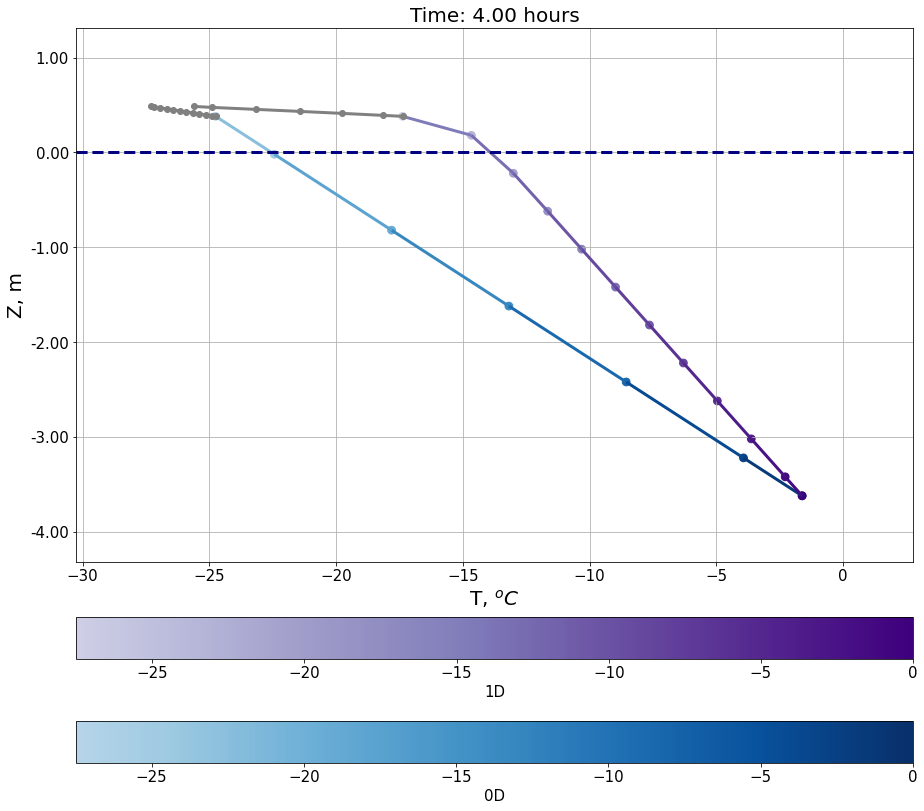

In [25]:
uv.animate([test_process_0d, test_process_1d], names=['0D','1D'])

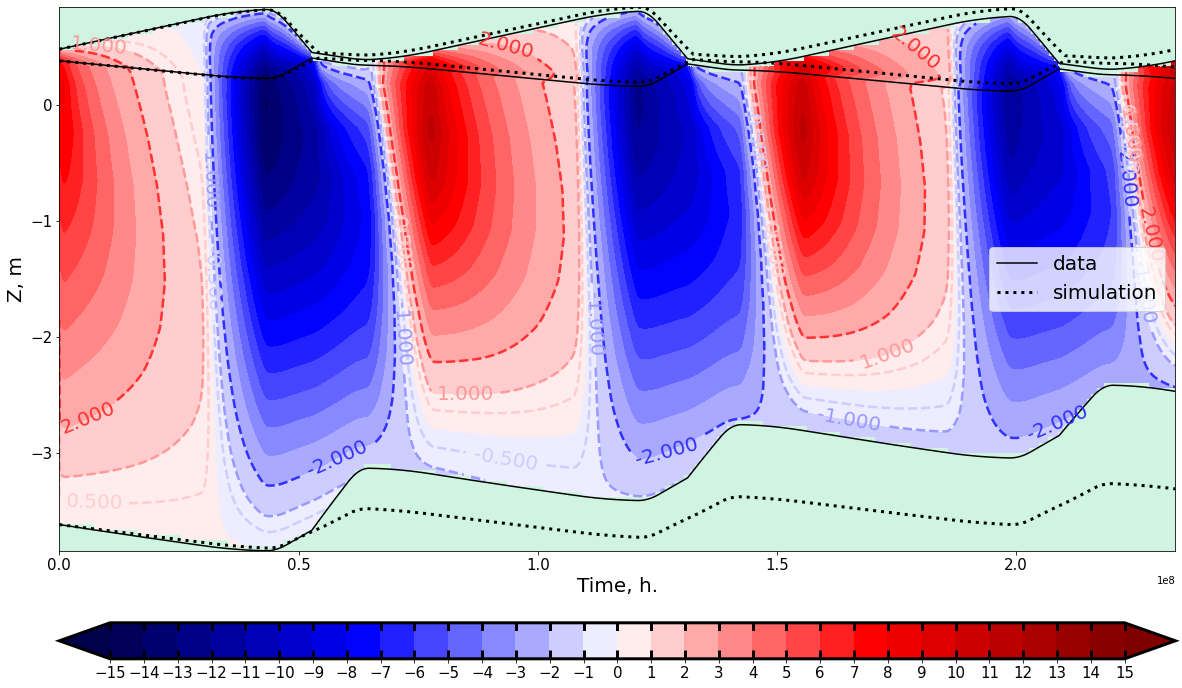

In [26]:
uv.timeseries_err(process_sim=test_process_1d,
                  process_data=test_process_0d,
                  tmin_err=-15., tmax_err=15., step_err=1.0,
                  figsize=(20, 10))

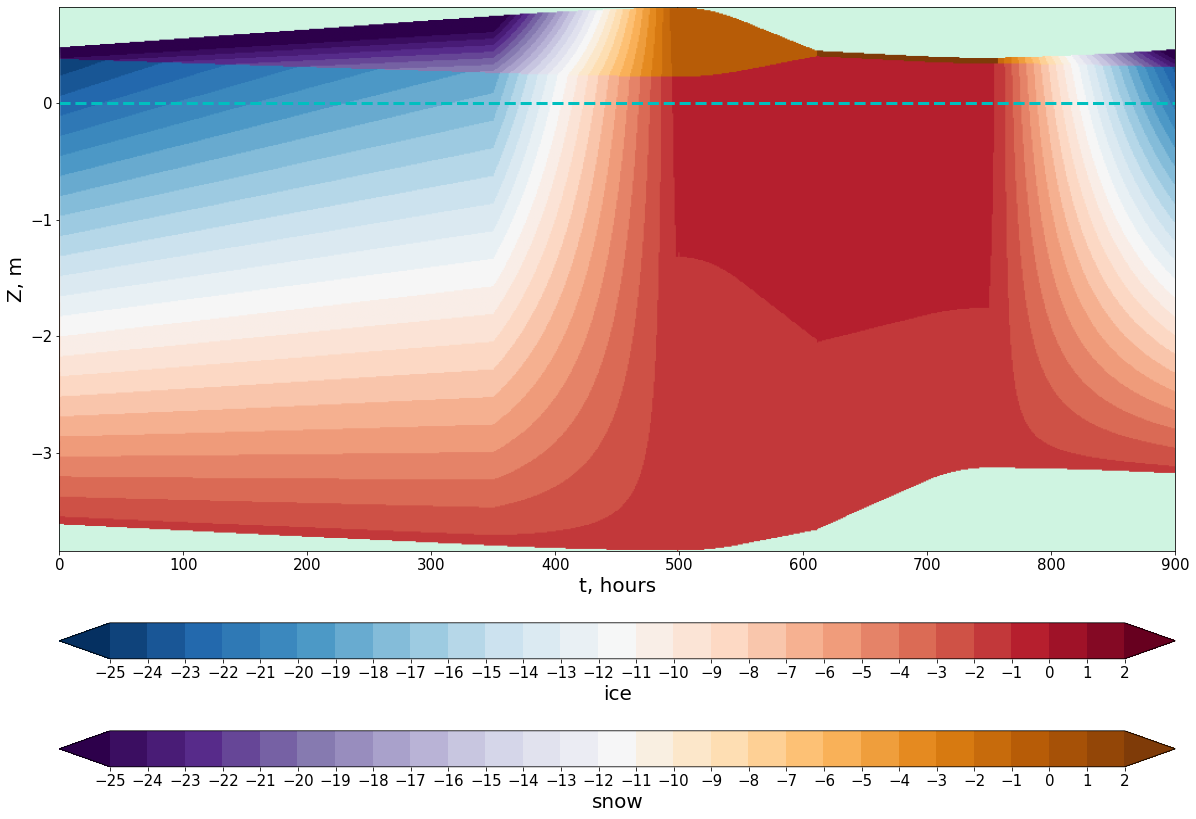

In [17]:
uv.timeseries_img(test_process_0d, y_points=500, figsize=(20, 10),
                  cmap_ice='RdBu_r', tmin_ice=-25, tmax_ice=2, step_ice=1.0,
                  cmap_snow='PuOr_r', tmin_snow=-25, tmax_snow=2, step_snow=1.0)